In [1]:
import pandas as pd
import numpy as np
from preprocessing import d_norm, i_norm, delete_hot_pixels
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', 20)
df = pd.read_excel("./data/data_merged_new.xlsx", index_col=0)
df.set_index("IDcard", inplace=True)
df.tail(5)

,AGE,SEX,GROUP,PARKINSON,STAGE,PD_duration (years),курение,АГ,СД,ХПН,...,803.694275,805.66482,807.635943,809.607641,811.579916,813.552766,815.526191,817.500191,819.474764,821.44991
IDcard,,,,,,,,,,,,,,,,,,,,,
КОНТРОЛЬ-4(П),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49,44,45,34,38,27,34,31,33,38
КОНТРОЛЬ-4(П),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40,37,36,38,33,26,21,28,30,25
КОНТРОЛЬ-4(П),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41,30,42,32,35,34,60,34,30,23
КОНТРОЛЬ-4(П),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36,40,34,39,34,42,31,28,38,41
КОНТРОЛЬ-4(П),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33,31,32,34,39,35,30,28,26,38


## Предобработка

In [2]:
df_raw = pd.read_excel("./data/df_raw.xlsx", index_col=[0, 1, 2])

Удаление горячих пикселей

In [3]:
pd.set_option('display.max_columns', 20)
df = pd.read_excel("./data/data_merged_new.xlsx", index_col=0)
df.set_index("IDcard", inplace=True)

group = []
for x in df.loc["БП008(Л)":].index:
    if "БП" in x:
        group.append("Parkinson")
    else:
        group.append("Control")
group = df.dropna(subset=["GROUP"])["GROUP"].to_list() + group
df["GROUP"] = group
df.reset_index(inplace=True)
df["level_3"] =  [x + f"_{i % 8 + 1}" for i, x in enumerate(df["IDcard"])]
df.set_index(["GROUP", "IDcard", "level_3"], inplace=True)
df = df.loc[:, 401.733364293274:].T

for col in df.columns:
    df[col] = delete_hot_pixels(df[col].to_list(), q=0.87, window=3)

df_raw = df.T
# df_raw.rename(columns=lambda x: str(int(x)))
# df = d_norm(df.T)
# df = df.merge(i_norm(df), right_index=True, left_index=True)

Сглаживание

In [280]:
from scipy.signal import savgol_filter

def smooth(data: pd.DataFrame, window_length:int=7, polyorder:int=3) -> pd.DataFrame:
    data_sm = None
    for y in data.to_numpy():
        y_smooth = savgol_filter(y, window_length, polyorder)
        if data_sm is None:
            data_sm = y_smooth
        else:
            data_sm = np.vstack((data_sm, y_smooth))
    df_sm = pd.DataFrame(data_sm, index=data.index, columns=data.columns)
    return df_sm

Коррекция базовой линиии и нормировка MinMax

In [281]:
from pybaselines import Baseline
import numpy as np

def min_max(y: np.ndarray) -> np.ndarray:
    y_norm = (y - y.min(axis=1, keepdims=True)) / (y.max(axis=1, keepdims=True) - y.min(axis=1, keepdims=True))
    return y_norm
# Создание объекта Baseline
baseline_fitter = Baseline()

# corrected_baseline = baseline_fitter.adaptive_minmax(y, poly_order=1)
data_base = None

for ind in df_raw.index:
    y = df_raw.loc[ind].to_numpy()
    corrected_baseline = baseline_fitter.asls(y, lam=1e5, p=0.0001)
    corrected_spectrum = y - corrected_baseline[0]
    if data_base is None:
        data_base = corrected_spectrum
    else:
        data_base = np.vstack((data_base, corrected_spectrum))

data_norm = min_max(data_base)
# lam (λ) — параметр сглаживания, p — асимметрия (0.001–0.1 для пиков)
df_minmax_norm = pd.DataFrame(data_base, index=df_raw.index, columns=df_raw.columns)
df_minmax_norm = smooth(df_minmax_norm)

In [76]:
df_minmax_norm = min_max(df_raw.to_numpy())
df_minmax_norm = pd.DataFrame(df_minmax_norm, index=df_raw.index, columns=df_raw.columns)

D и I нормировки

In [292]:
df_idnorm = d_norm(df_raw)
df_idnorm = df_idnorm.merge(i_norm(df_idnorm), right_index=True, left_index=True)
df_idnorm.to_excel("./data/df_idnorm.xlsx")

### Статистический анализ

In [3]:
df_norm = pd.read_excel("./data/data_for_classification.xlsx", index_col=[0, 1, 2])
df_norm.head(5)

401       403       405       407       409  \
GROUP   IDcard level_3                                                     
Control CG1    CG1_1    0.210526  0.182815  0.199123  0.195652  0.191928   
               CG1_2    0.161722  0.155393  0.157895  0.152174  0.157331   
               CG1_3    0.141627  0.119744  0.128947  0.127090  0.129325   
               CG1_4    0.129187  0.111517  0.120175  0.108696  0.118616   
               CG1_5    0.115789  0.112431  0.112281  0.112040  0.113674   

                             410       412       414       416       418  ...  \
GROUP   IDcard level_3                                                    ...   
Control CG1    CG1_1    0.201283  0.193822  0.198502  0.194524  0.197609  ...   
               CG1_2    0.158781  0.154440  0.156554  0.157781  0.154712  ...   
               CG1_3    0.130714  0.131274  0.135581  0.137608  0.132911  ...   
               CG1_4    0.115477  0.120463  0.119101  0.123199  0.113924  ...   
               CG1_5    0.109062  0.122780  0.116854  0.116715  0.117440  ...   

                             803       805       807       809       811  \
GROUP   IDcard level_3                                                     
Control CG1    CG1_1    0.425287  0.411765  0.337079  0.448276  0.358974   
               CG1_2    0.321839  0.400000  0.370787  0.459770  0.307692   
               CG1_3    0.195402  0.294118  0.303371  0.333333  0.397436   
               CG1_4    0.333333  0.223529  0.269663  0.298851  0.217949   
               CG1_5    0.264368  0.270588  0.202247  0.229885  0.179487   

                             813       815       817       819       821  
GROUP   IDcard level_3                                                    
Control CG1    CG1_1    0.494118  0.495238  0.436620  0.416667  0.439394  
               CG1_2    0.435294  0.419048  0.197183  0.444444  0.333333  
               CG1_3    0.352941  0.395238  0.295775  0.291667  0.287879  
               CG1_4    0.282353  0.490476  0.281690  0.347222  0.378788  
               CG1_5    0.329412  0.433333  0.394366  0.319444  0.318182  

[5 rows x 221 columns]

In [ ]:
from scipy import stats
def compute_Z(data, start, stop):
    """
        Функция для рассчета Z-оценок по подгруппам Паркинсон, Контроль, Сравнение
        
        data: pd.DataFrame - данные
        start: pd.Index - начало исследуемого участка спектра
        stop: pd.Index - конец исследуемого участка
    """
    Z_cont_park = []
    Z_comp_park = []
    Z_comp_cont = []
    df_cont = data.loc[data.index.get_level_values(level=0) == "Control", start:stop].copy()
    df_park = data.loc[data.index.get_level_values(level=0) == "Parkinson", start:stop].copy()
    df_comp = data.loc[data.index.get_level_values(level=0) == "Comparison", start:stop].copy()
    try:
        preds = [int(val)for val in df_cont.keys()]
    except:
        preds = [int(val[1:])for val in df_cont.keys()]
    
    n1 = len(df_cont)
    n2 = len(df_park)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in df_cont.keys():
        U, p = stats.mannwhitneyu(df_cont[predictor], df_park[predictor])
        Z_cont_park.append((float(U) - mU) / sigma_U)
    n1 = len(df_comp)
    n2 = len(df_park)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in df_cont.keys():
        U, p = stats.mannwhitneyu(df_comp[predictor], df_park[predictor])
        Z_comp_park.append((float(U) - mU) / sigma_U)
    n1 = len(df_comp)
    n2 = len(df_cont)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in df_cont.keys():
        U, p = stats.mannwhitneyu(df_comp[predictor], df_cont[predictor])
        Z_comp_cont.append((float(U) - mU) / sigma_U)
    
    return Z_cont_park, Z_comp_park, Z_comp_cont, preds

In [69]:
def draw_z(Z, Z_name, preds):
    fig_Z = plt.figure()
    for z in Z:
        plt.plot(preds, z, linewidth=2)
    Z_crit = [2.39] * len(preds)
    plt.plot(preds, Z_crit,
         linewidth=2,      # Толщина линии (можно сократить lw)
         linestyle='--',   # Стиль линии (можно сократить ls)
         color='red',      # Цвет (можно сократить c)
         alpha=0.7)        # Прозрачность (0-1))
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Z score, a.u.")
    plt.grid(True)
    plt.legend(Z_name + ["Z critical (p = 0.05)"])

    plt.show()

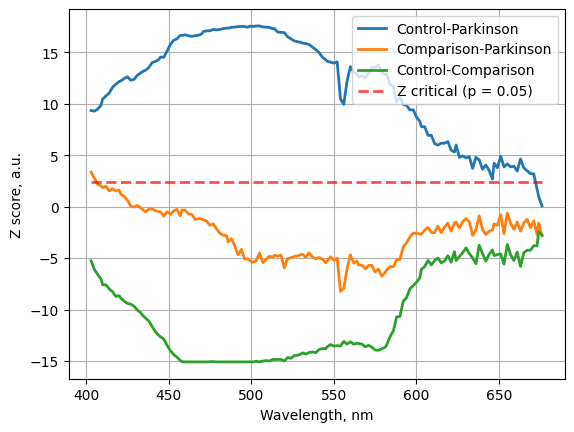

In [212]:
Z_cont_park, Z_comp_park, Z_comp_cont, preds = compute_Z(df_idnorm, start="I403", stop="I676")
z = np.array([Z_cont_park, Z_comp_park, Z_comp_cont])
Z_name = ["Control-Parkinson", "Comparison-Parkinson", "Control-Comparison"]
draw_z(z, Z_name, preds)

In [78]:
def print_z_info(z, Z_name):
    z = np.array(z)
    Z_min = np.min(z, axis=1)
    Z_max = np.max(z, axis=1)
    Z_mean = np.mean(z, axis=1)
    Z_std = np.std(z, axis=1)
    for z_min, z_max, z_mean, z_std, z_name in zip(Z_min, Z_max, Z_mean, Z_std, Z_name):
        print(f"{z_name}")
        print(f"min: {z_min}")
        print(f"max: {z_max}")
        print(f"mean: {z_mean}")
        print(f"std: {z_std}")
        print()

In [79]:
print_z_info(z, Z_name)

Control-Parkinson
min: 8.49169713426897
max: 9.340155637607461
mean: 8.88041770387937
std: 0.22245995395190804

Comparison-Parkinson
min: 7.35573916788906
max: 8.906732657951355
mean: 8.415761318700394
std: 0.32003372499171095

Control-Comparison
min: 0.43941491976165525
max: 1.7431535468949295
mean: 1.0719137446474234
std: 0.32503936724332516



In [7]:
def sigma(x, mean):
    N = len(mean)
    return (np.sum((x - mean) ** 2, axis=0) / N) ** 0.5

In [213]:
cont_mean = df_raw.loc["Control", "401":"676"].mean(axis=0).to_numpy()
park_mean = df_raw.loc["Parkinson", "401":"676"].mean(axis=0).to_numpy()
comp_mean = df_raw.loc["Comparison", "401":"676"].mean(axis=0).to_numpy()

sigma_cont = sigma(df_raw.loc["Control", "401":"676"].to_numpy(), cont_mean)
sigma_park = sigma(df_raw.loc["Parkinson", "401":"676"].to_numpy(), park_mean)
sigma_comp = sigma(df_raw.loc["Comparison", "401":"676"].to_numpy(), comp_mean)

#plt.errorbar(list(map(int, df_raw.loc[:, "401":"676"].columns.to_list())), cont_mean.T, yerr=sigma_cont, linewidth=2, linestyle="-")
plt.errorbar(list(map(int, df_raw.loc[:, "401":"676"].columns.to_list())), park_mean.T, yerr=sigma_park, linewidth=2, linestyle="--")
#plt.errorbar(list(map(int, df_raw.loc[:, "401":"676"].columns.to_list())), comp_mean.T, yerr=sigma_comp, linewidth=2, linestyle="-.")
plt.grid(True)
plt.ylabel("Intensity, a.u.")
plt.xlabel("Wavelength, nm")
plt.legend(["Control", "Parkinson", "Comparison"])

TypeError: '<' not supported between instances of 'float' and 'str'

In [282]:
df = df_minmax_norm

In [66]:
from typing import Union
def d_norm(data: Union[pd.Series, pd.DataFrame],
                laser_wave_left: Union[float, str] = 731.195121105382,
                laser_wave_right: Union[float, str] = 772.244519389919,
                cutoff_wave: Union[float, str] = 676.874469938485):
    if isinstance(data, pd.Series):
        data = data.loc[:cutoff_wave].div(
            data.loc[laser_wave_left:laser_wave_right].mean())
    else:
        data = data.loc[:, :cutoff_wave].div(
            data.loc[:, laser_wave_left:laser_wave_right].mean(axis=1),
            axis=0)
        data.rename(axis=1,
                    mapper=lambda x: f"D{int(x)}",
                    inplace=True)
    return data

In [67]:
df_dnorm = d_norm(df_raw.copy(), "731", "772", "676")

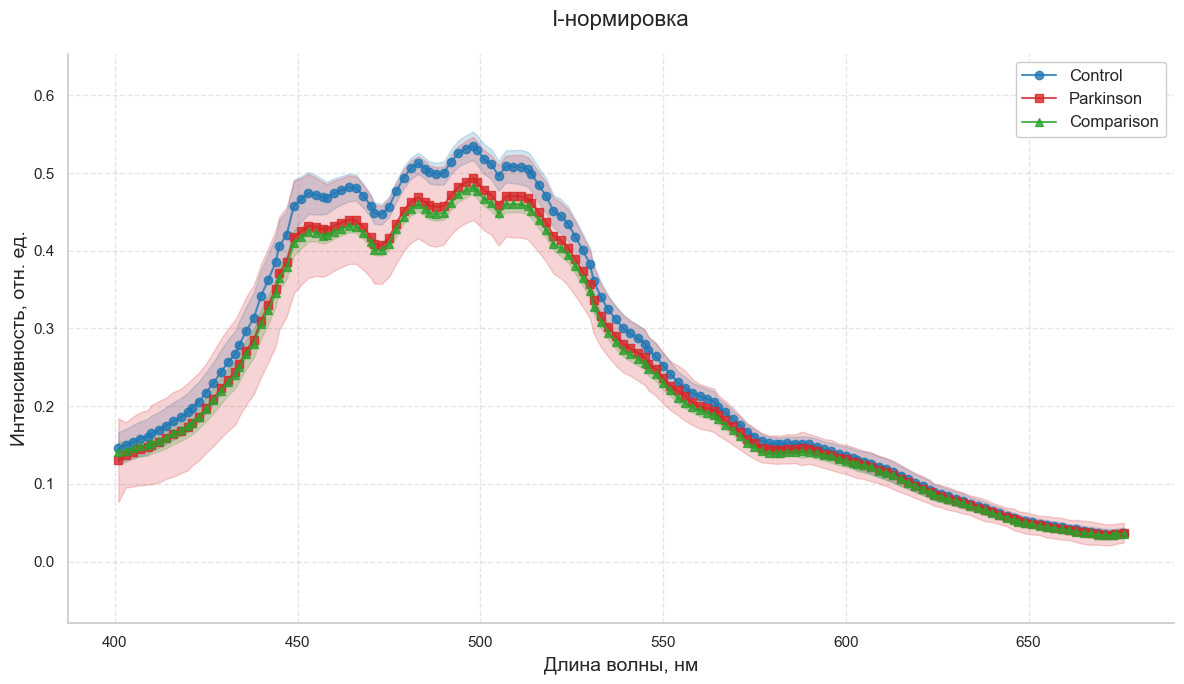

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

start, stop = "I401", "I676"
df = df_inorm.copy()
cont_mean = df.loc["Control", start:stop].mean(axis=0).to_numpy()
park_mean = df.loc["Parkinson", start:stop].mean(axis=0).to_numpy()
comp_mean = df.loc["Comparison", start:stop].mean(axis=0).to_numpy()

sigma_cont = sigma(df.loc["Control", start:stop].to_numpy(), cont_mean)
sigma_park = sigma(df.loc["Parkinson", start:stop].to_numpy(), park_mean)
sigma_comp = sigma(df.loc["Comparison", start:stop].to_numpy(), comp_mean)
# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Предполагаем, что у вас есть временная ось (например, x = np.arange(len(cont_mean)))
x = [int(x[1:]) for x in df_inorm.loc[:, "I401":"I676"].columns]

# Построение всех трех кривых с погрешностями
plt.errorbar(x, cont_mean, fmt='-o', 
             color='#1f77b4', ecolor='#1f77b4', alpha=0.8,
             label='Control', capsize=4, elinewidth=1.5)

plt.errorbar(x, park_mean, fmt='-s', 
             color='#d62728', ecolor='#d62728', alpha=0.8,
             label='Parkinson', capsize=4, elinewidth=1.5)

plt.errorbar(x, comp_mean, fmt='-^', 
             color='#2ca02c', ecolor='#2ca02c', alpha=0.8,
             label='Comparison', capsize=4, elinewidth=1.5)
plt.fill_between(x, cont_mean - sigma_cont, cont_mean + sigma_cont, 
                   color='#1f77b4', alpha=0.2)
plt.fill_between(x, park_mean - sigma_park, park_mean + sigma_park, 
                   color='#d62728', alpha=0.2)
plt.fill_between(x, comp_mean - sigma_comp, comp_mean + sigma_comp, 
                   color='#2ca02c', alpha=0.2)
# Дополнительное оформление

plt.xlabel('Длина волны, нм', fontsize=14)
plt.ylabel('Интенсивность, отн. ед.', fontsize=14)
plt.title("I-нормировка", fontsize=16, pad=20)
plt.legend(fontsize=12, framealpha=1)

# Настройка сетки и осей

plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()

# Автоматическое масштабирование осей с запасом для погрешностей
ymin = min(np.min(cont_mean - sigma_cont), 
           np.min(park_mean - sigma_park), 
           np.min(comp_mean - sigma_comp)) - 0.1
ymax = max(np.max(cont_mean + sigma_cont), 
           np.max(park_mean + sigma_park), 
           np.max(comp_mean + sigma_comp)) + 0.1
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

<Figure size 2000x800 with 0 Axes>

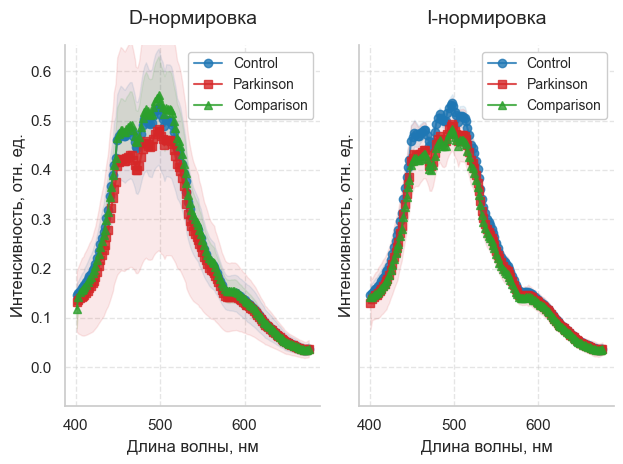

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(20, 8))  # Увеличиваем размер для двух графиков

# Создаем подграфики (1 строка, 2 столбца)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)  # sharey для одинаковых осей Y

# Общая функция для построения (чтобы избежать дублирования кода)
def plot_data(ax, x, cont_mean, park_mean, comp_mean, 
              sigma_cont, sigma_park, sigma_comp, title):
    """Построение одного подграфика с тремя группами данных"""
    # Построение всех трех кривых с погрешностями
    ax.errorbar(x, cont_mean, fmt='-o', 
                color='#1f77b4', ecolor='#1f77b4', alpha=0.8,
                label='Control', capsize=4, elinewidth=1.5)
    ax.errorbar(x, park_mean, fmt='-s', 
                color='#d62728', ecolor='#d62728', alpha=0.8,
                label='Parkinson', capsize=4, elinewidth=1.5)
    ax.errorbar(x, comp_mean, fmt='-^', 
                color='#2ca02c', ecolor='#2ca02c', alpha=0.8,
                label='Comparison', capsize=4, elinewidth=1.5)
    
    # Заполнение областей СКО (опционально)
    ax.fill_between(x, cont_mean - sigma_cont, cont_mean + sigma_cont, 
                   color='#1f77b4', alpha=0.1)
    ax.fill_between(x, park_mean - sigma_park, park_mean + sigma_park, 
                   color='#d62728', alpha=0.1)
    ax.fill_between(x, comp_mean - sigma_comp, comp_mean + sigma_comp, 
                   color='#2ca02c', alpha=0.1)
    
    # Настройка оформления
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_xlabel('Длина волны, нм', fontsize=12)
    ax.set_ylabel('Интенсивность, отн. ед.', fontsize=12)
    ax.legend(fontsize=10, framealpha=1)
    ax.grid(True, linestyle='--', alpha=0.5)
    sns.despine(ax=ax)
    
    # Автомасштабирование осей Y
    ymin = min(np.min(cont_mean - sigma_cont), 
               np.min(park_mean - sigma_park), 
               np.min(comp_mean - sigma_comp)) - 0.1
    ymax = max(np.max(cont_mean + sigma_cont), 
               np.max(park_mean + sigma_park), 
               np.max(comp_mean + sigma_comp)) + 0.1
    ax.set_ylim(ymin, ymax)

# Данные для первого подграфика (ваши исходные данные)
start, stop = "D401", "D676"
df = df_dnorm.copy()
cont_mean = df.loc["Control", start:stop].mean(axis=0).to_numpy()
park_mean = df.loc["Parkinson", start:stop].mean(axis=0).to_numpy()
comp_mean = df.loc["Comparison", start:stop].mean(axis=0).to_numpy()

sigma_cont = sigma(df.loc["Control", start:stop].to_numpy(), cont_mean)
sigma_park = sigma(df.loc["Parkinson", start:stop].to_numpy(), park_mean)
sigma_comp = sigma(df.loc["Comparison", start:stop].to_numpy(), comp_mean)

plot_data(ax1, x, cont_mean, park_mean, comp_mean, 
          sigma_cont, sigma_park, sigma_comp, 
          title="D-нормировка")

# Данные для второго подграфика (предполагаем, что есть аналогичные данные)
# Пример: можно использовать срезы или другие колонки из DataFrame
start, stop = "I401", "I676"
df = df_inorm.copy()
cont_mean = df.loc["Control", start:stop].mean(axis=0).to_numpy()
park_mean = df.loc["Parkinson", start:stop].mean(axis=0).to_numpy()
comp_mean = df.loc["Comparison", start:stop].mean(axis=0).to_numpy()

sigma_cont = sigma(df.loc["Control", start:stop].to_numpy(), cont_mean)
sigma_park = sigma(df.loc["Parkinson", start:stop].to_numpy(), park_mean)
sigma_comp = sigma(df.loc["Comparison", start:stop].to_numpy(), comp_mean)



plot_data(ax2, x, cont_mean, park_mean, comp_mean, 
          sigma_cont, sigma_park, sigma_comp, 
          title="I-нормировка")


plt.tight_layout()
plt.show()

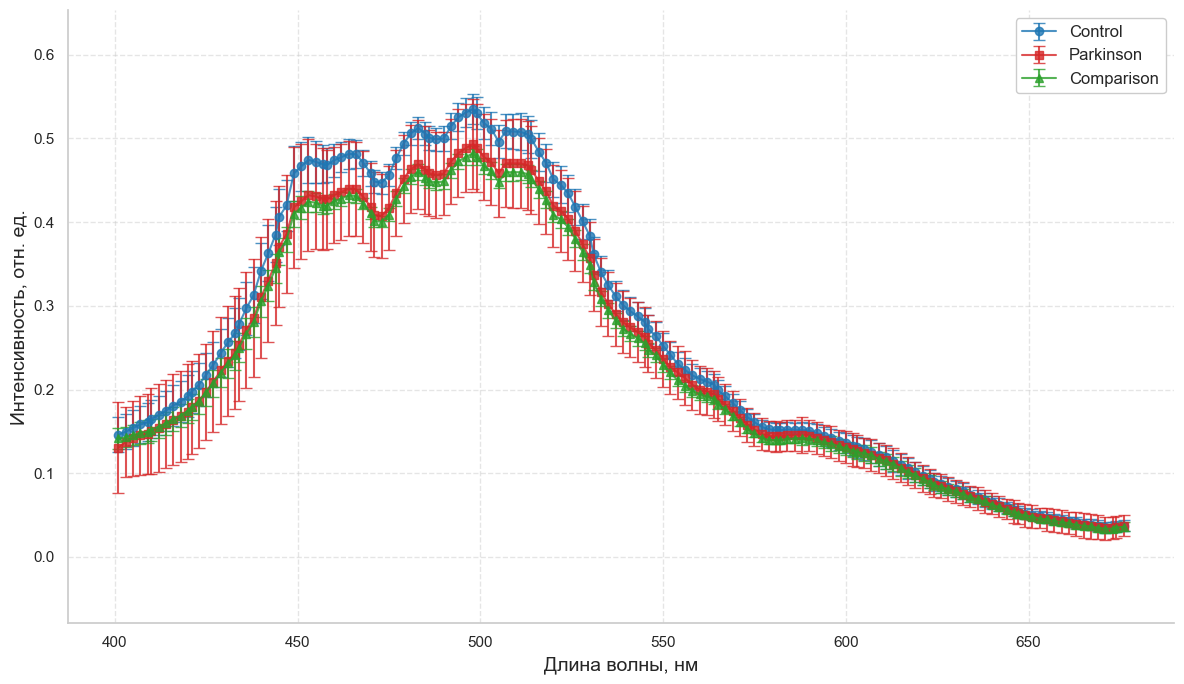

In [86]:
start, stop = "I401", "I676"
df = df_inorm.copy()
cont_mean = df.loc["Control", start:stop].mean(axis=0).to_numpy()
park_mean = df.loc["Parkinson", start:stop].mean(axis=0).to_numpy()
comp_mean = df.loc["Comparison", start:stop].mean(axis=0).to_numpy()

sigma_cont = sigma(df.loc["Control", start:stop].to_numpy(), cont_mean)
sigma_park = sigma(df.loc["Parkinson", start:stop].to_numpy(), park_mean)
sigma_comp = sigma(df.loc["Comparison", start:stop].to_numpy(), comp_mean)
# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Предполагаем, что у вас есть временная ось (например, x = np.arange(len(cont_mean)))
x = [int(x[1:]) for x in df_inorm.loc[:, "I401":"I676"].columns]

# Построение всех трех кривых с погрешностями
plt.errorbar(x, cont_mean, yerr=sigma_cont, fmt='-o', 
             color='#1f77b4', ecolor='#1f77b4', alpha=0.8,
             label='Control', capsize=4, elinewidth=1.5)

plt.errorbar(x, park_mean, yerr=sigma_park, fmt='-s', 
             color='#d62728', ecolor='#d62728', alpha=0.8,
             label='Parkinson', capsize=4, elinewidth=1.5)

plt.errorbar(x, comp_mean, yerr=sigma_comp, fmt='-^', 
             color='#2ca02c', ecolor='#2ca02c', alpha=0.8,
             label='Comparison', capsize=4, elinewidth=1.5)

# Дополнительное оформление

plt.xlabel('Длина волны, нм', fontsize=14)
plt.ylabel('Интенсивность, отн. ед.', fontsize=14)
plt.legend(fontsize=12, framealpha=1)

# Настройка сетки и осей
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()

# Автоматическое масштабирование осей с запасом для погрешностей
ymin = min(np.min(cont_mean - sigma_cont), 
           np.min(park_mean - sigma_park), 
           np.min(comp_mean - sigma_comp)) - 0.1
ymax = max(np.max(cont_mean + sigma_cont), 
           np.max(park_mean + sigma_park), 
           np.max(comp_mean + sigma_comp)) + 0.1
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [ ]:
def draw_mean_specs(df, start, stop, x=None):
    cont_mean = df.loc["Control", start:stop].mean(axis=0).to_numpy()
    park_mean = df.loc["Parkinson", start:stop].mean(axis=0).to_numpy()
    comp_mean = df.loc["Comparison", start:stop].mean(axis=0).to_numpy()

    sigma_cont = sigma(df.loc["Control", start:stop].to_numpy(), cont_mean)
    sigma_park = sigma(df.loc["Parkinson", start:stop].to_numpy(), park_mean)
    sigma_comp = sigma(df.loc["Comparison", start:stop].to_numpy(), comp_mean)
    if x is None:
        x = list(map(int, df.loc[:, start:stop].columns.to_list()))
    plt.errorbar(x, cont_mean.T, yerr=sigma_cont, linewidth=2, linestyle="-")
    plt.errorbar(x, park_mean.T, yerr=sigma_park, linewidth=2, linestyle="--")
    plt.errorbar(x, comp_mean.T, yerr=sigma_comp, linewidth=2, linestyle="-.")
    plt.grid(True)

    plt.ylabel("Intensity, a.u.")
    plt.xlabel("Wavelength, nm")
    plt.legend(["Control", "Parkinson", "Comparison"])

In [71]:
df_inorm = i_norm(df_dnorm)

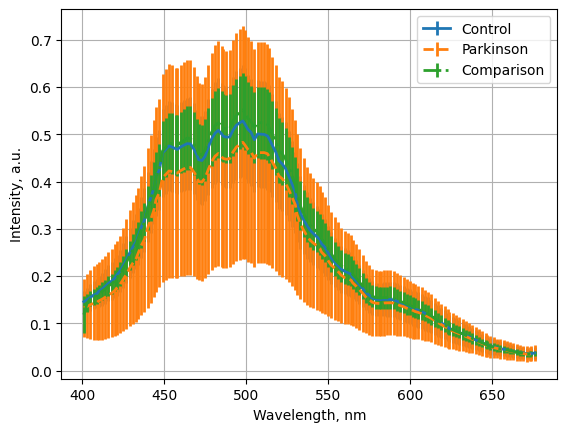

In [70]:
draw_mean_specs(df_dnorm, "D401", "D676", x = [int(x[1:]) for x in df_dnorm.loc[:, "D401":"D676"].columns])

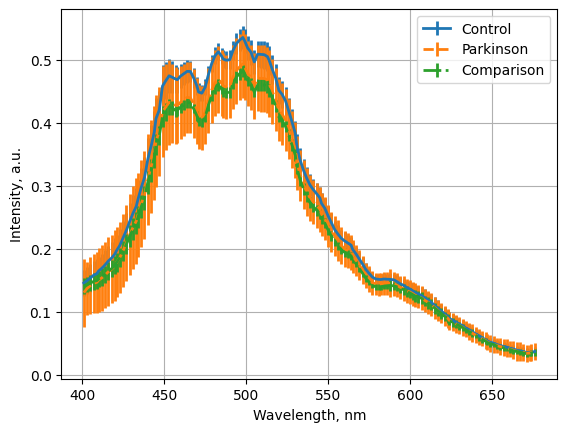

In [72]:
draw_mean_specs(df_inorm, "I401", "I676", x = [int(x[1:]) for x in df_inorm.loc[:, "I401":"I676"].columns])

### Разделение на выборки

In [4]:
from typing import Union
def d_norm(data: Union[pd.Series, pd.DataFrame],
                laser_wave_left: float = 731.195121105382,
                laser_wave_right: float = 772.244519389919,
                cutoff_wave: float = 676.874469938485):
    if isinstance(data, pd.Series):
        data = data.loc[:cutoff_wave].div(
            data.loc[laser_wave_left:laser_wave_right].mean())
    else:
        data = data.loc[:, :cutoff_wave].div(
            data.loc[:, laser_wave_left:laser_wave_right].mean(axis=1),
            axis=0)
        data.rename(axis=1,
                    mapper=lambda x: f"D{int(x)}",
                    inplace=True)
    return data

In [ ]:
df = d_norm(df_raw, "731", "772", "676")

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

idx = pd.IndexSlice
X = df_raw.copy()
y = pd.Series([1 if x == "Parkinson" else 0 for x in df.index.get_level_values("GROUP").to_list()], index = df_raw.index)
y_buf = y.groupby(level=1).max()
y_temp, y_val = train_test_split(y_buf, stratify=y_buf, test_size=0.4, random_state=33)
y_train, y_test = train_test_split(y_temp, stratify=y_temp, test_size=0.5, random_state=33)
X_train = X.loc[idx[:, y_train.index, :]]
X_val = X.loc[idx[:, y_val.index, :]]
y_train = y.loc[idx[:, y_train.index, :]]
y_val = y.loc[idx[:, y_val.index, :]]

X_train = d_norm(X_train, "731", "772", "676")
X_val = d_norm(X_val, "731", "772", "676")

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

idx = pd.IndexSlice
X = df.loc[:, "D401":"676"].copy()
y = pd.Series([1 if x == "Parkinson" else 0 for x in df.index.get_level_values("GROUP").to_list()], index = df.index)
y_buf = y.groupby(level=1).max()
y_train, y_val = train_test_split(y_buf, stratify=y_buf, test_size=0.25, random_state=33)
X_train = X.loc[idx[:, y_train.index, :]]
X_val = X.loc[idx[:, y_val.index, :]]
y_train = y.loc[idx[:, y_train.index, :]]
y_val = y.loc[idx[:, y_val.index, :]]

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

idx = pd.IndexSlice
X = df_norm.loc[:, "I401":"I676"].copy()
y = pd.Series([1 if x == "Parkinson" else 0 for x in df_norm.index.get_level_values("GROUP").to_list()], index = df_norm.index)
y_buf = y.groupby(level=1).max()
y_train, y_val = train_test_split(y_buf, stratify=y_buf, test_size=0.25, random_state=33)
X_train = X.loc[idx[:, y_train.index, :]]
X_val = X.loc[idx[:, y_val.index, :]]
y_train = y.loc[idx[:, y_train.index, :]]
y_val = y.loc[idx[:, y_val.index, :]]

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

idx = pd.IndexSlice
X = df_norm.loc[:, "D401":"D676"].copy()
y = pd.Series([1 if x == "Parkinson" else 0 for x in df_norm.index.get_level_values("GROUP").to_list()], index = df_norm.index)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=33)

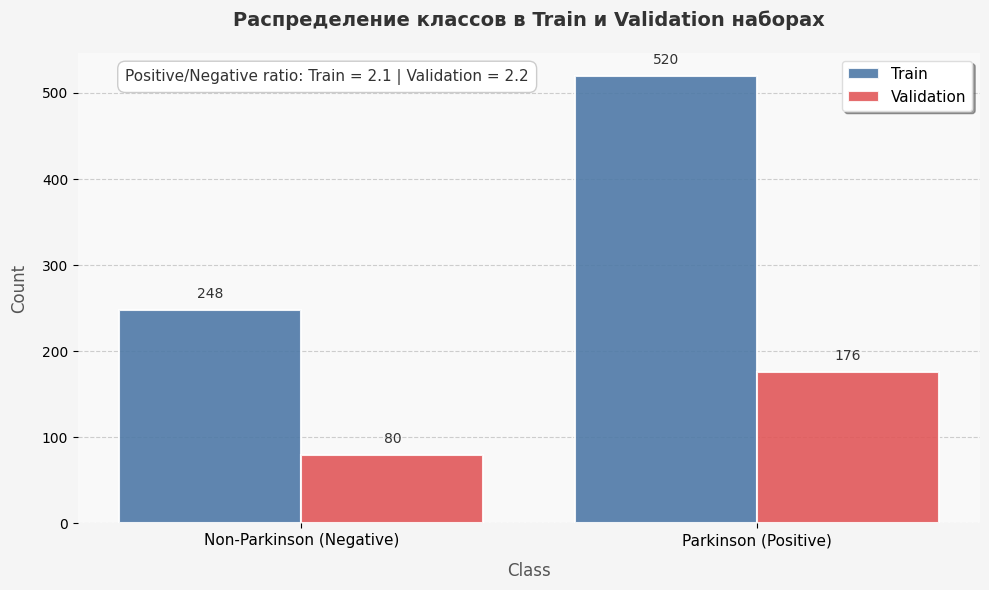

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Генерация данных (замените на свои)
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)

# Подсчёт количества элементов каждого класса
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)

# Стиль графика
plt.style.use('seaborn-v0_8-pastel')  # Мягкие цвета
sns.set_palette("husl")  # Красивая палитра

# Настройка размера и фона
plt.figure(figsize=(10, 6), facecolor='#f5f5f5')
plt.gca().set_facecolor('#f9f9f9')

# Ширина столбцов
width = 0.4

# Цвета (можно выбрать любые из палитры seaborn)
train_color = '#4e79a7'  # Приятный синий
val_color = '#e15759'    # Тёплый красный

# Столбцы для тренировочных данных
bars_train = plt.bar(
    np.arange(2) - width/2, train_counts, width,
    label='Train', color=train_color, edgecolor='white', linewidth=1.5,
    alpha=0.9, zorder=3
)

# Столбцы для валидационных данных
bars_val = plt.bar(
    np.arange(2) + width/2, val_counts, width,
    label='Validation', color=val_color, edgecolor='white', linewidth=1.5,
    alpha=0.9, zorder=3
)

# Добавление аннотаций (количества)
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height + max(train_counts.max(), val_counts.max()) * 0.02,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, color='#333333'
        )

add_labels(bars_train)
add_labels(bars_val)

# Настройка осей и заголовка
plt.title(
    'Распределение классов в Train и Validation наборах', 
    fontsize=14, pad=20, fontweight='bold', color='#333333'
)
plt.xlabel('Class', fontsize=12, labelpad=10, color='#555555')
plt.ylabel('Count', fontsize=12, labelpad=10, color='#555555')
plt.xticks([0, 1], ['Non-Parkinson (Negative)', 'Parkinson (Positive)'], fontsize=11)
plt.yticks(fontsize=10)

# Легенда
plt.legend(
    frameon=True, shadow=True, facecolor='white', 
    edgecolor='#dddddd', fontsize=11, loc='upper right'
)

# Добавление информации о дисбалансе
train_ratio_park = train_counts[1] 
val_ratio_park = val_counts[1]
train_ratio_non = len(y_train) - train_ratio_park
val_ratio_non = len(y_val) - val_ratio_park 
train_ratio = float(train_ratio_park / train_ratio_non)
val_ratio = float(val_ratio_park / val_ratio_non)
plt.text(
    0.5, 0.95, 
    f'Positive/Negative ratio: Train = {train_ratio:.1f} | Validation = {val_ratio:.1f}', 
    ha='right', va='center', transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', edgecolor='#cccccc', boxstyle='round,pad=0.5'),
    fontsize=11, color='#333333'
)

# Сетка и оформление
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
sns.despine(left=True, bottom=True)  # Убираем верхнюю и правую границы

# Улучшенное расположение элементов
plt.tight_layout()

plt.show()

### Обучение

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import rcParams

def draw_roc_curve(y_true: np.ndarray, 
                   proba_all: list, 
                   y_pred_all: list, 
                   names: list,
                   figsize=(10, 8),
                   linewidth=2,
                   diagonal_alpha=0.5,
                   style='ggplot',
                   palette='viridis'):
    """
    Улучшенная визуализация ROC-кривых для нескольких моделей
    
    Параметры:
    ----------
    y_true : np.ndarray
        Истинные метки классов (1D массив)
    proba_all : list
        Список предсказанных вероятностей для положительного класса
    y_pred_all : list
        Список предсказанных классов
    names : list
        Названия моделей (для легенды)
    figsize : tuple
        Размер графика (ширина, высота)
    linewidth : int
        Толщина линий ROC-кривых
    diagonal_alpha : float
        Прозрачность диагональной пунктирной линии
    style : str
        Стиль matplotlib (доступные: 'ggplot', 'seaborn', 'default' и др.)
    palette : str
        Название цветовой палитры ('viridis', 'plasma', 'tab10' и др.)
    """
    
    # Проверка доступных стилей
    available_styles = plt.style.available
    if style not in available_styles:
        print(f"Стиль '{style}' недоступен. Используются стандартные настройки.")
        print(f"Доступные стили: {available_styles}")
        style = 'default'
    
    # Применение стиля
    plt.style.use(style)
    
    # Настройка параметров
    rcParams.update({
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'grid.alpha': 0.3
    })
    
    # Создание фигуры
    fig, ax = plt.subplots(figsize=figsize)
    
    # Диагональная линия (random classifier)
    ax.plot([0, 1], [0, 1], 
            linestyle='--', 
            color='gray', 
            alpha=diagonal_alpha,
            label='Random (AUC = 0.5)')
    
    # Получение цветов из палитры
    colors = plt.get_cmap(palette, len(names))
    
    # Построение ROC-кривых для каждой модели
    for i, (proba, y_pred, name) in enumerate(zip(proba_all, y_pred_all, names)):
        auc_score = roc_auc_score(y_true, proba)
        fpr, tpr, _ = roc_curve(y_true, proba, pos_label=1)
        
        ax.plot(fpr, tpr, 
                linewidth=linewidth,
                color=colors(i),
                label=f'{name} (AUC = {auc_score:.3f})')
    
    # Настройка отображения
    ax.set_title('ROC-кривые моделей', pad=20)
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.grid(True)
    ax.legend(frameon=True, framealpha=0.9, fontsize=12)
    
    # Добавление информации о данных
    # ax.annotate(f'Общее количество: {len(y_true)}\nПоложительный класс: {sum(y_true)}\nОтрицательный класс: {len(y_true)-sum(y_true)}',
    #             xy=(0.98, 0.02), 
    #             xycoords='axes fraction',
    #             ha='right', 
    #             va='bottom',
    #             fontsize=12,
    #             bbox=dict(boxstyle='round', alpha=0.2))
    
    # Установка границ
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    # Улучшенное отображение
    plt.tight_layout()
    plt.show()

In [40]:
proba_all = []
y_pred_all = []
clf_name = []
for c in [0.1, 1., 10., 50., 100.]:
    clf = SVC(class_weight="balanced", probability=True, kernel="rbf", gamma="scale", random_state=42, C=c)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    proba = clf.predict_proba(X_val)[:, 1]
    proba_all.append(proba)
    y_pred_all.append(y_pred)
    clf_name.append(f"C = {c}")

In [39]:
proba_all = []
y_pred_all = []
clf_name = []
clf_svc = SVC(class_weight="balanced", probability=True, kernel="rbf", gamma="scale", random_state=42, C=1)
clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_val)
proba = clf_svc.predict_proba(X_val)[:, 1]
proba_all.append(proba)
y_pred_all.append(y_pred)
clf_name.append(f"SVM")

In [23]:
from sklearn.metrics import precision_score, accuracy_score, recall_score

def print_metrics(y_true, y_pred, name: "Undefined"):
    print(f"{name} classifier:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Precision: {precision_score(y_true, y_pred):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred):.2f}")
    print("-" * 50)

In [42]:
for y_pred, name in zip(y_pred_all, clf_name):
    print_metrics(y_val, y_pred, name)

C = 0.1 classifier:
Accuracy: 0.68
Precision: 0.75
Recall: 0.78
--------------------------------------------------
C = 1.0 classifier:
Accuracy: 0.75
Precision: 0.76
Recall: 0.92
--------------------------------------------------
C = 10.0 classifier:
Accuracy: 0.70
Precision: 0.77
Recall: 0.80
--------------------------------------------------
C = 50.0 classifier:
Accuracy: 0.72
Precision: 0.80
Recall: 0.78
--------------------------------------------------
C = 100.0 classifier:
Accuracy: 0.74
Precision: 0.80
Recall: 0.81
--------------------------------------------------


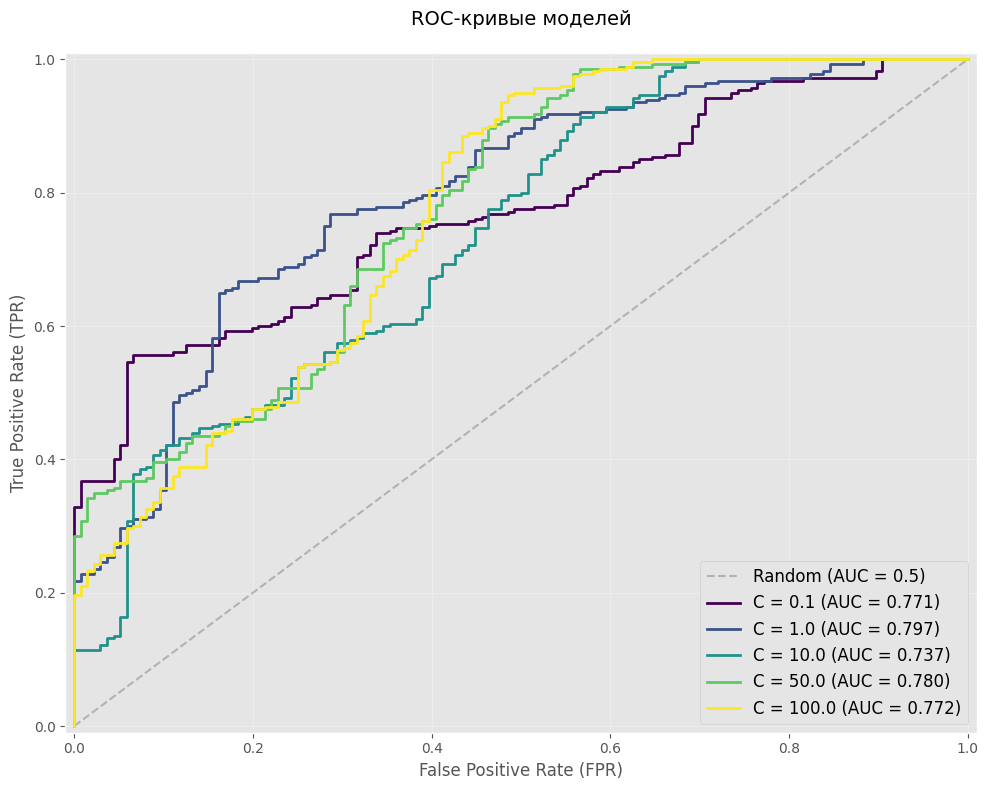

In [41]:
draw_roc_curve(y_val, proba_all, y_pred_all, clf_name)

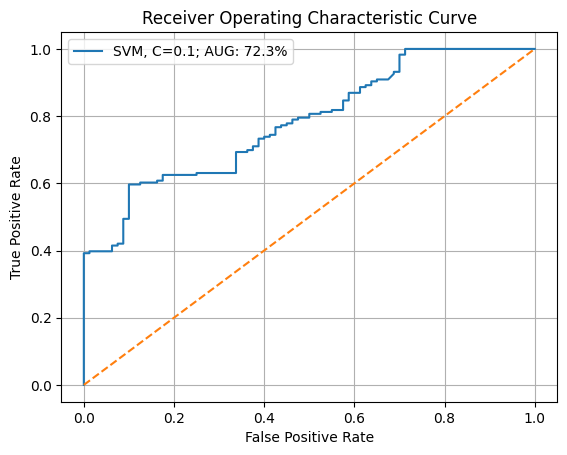

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
def draw_infograph(y_true: np.ndarray, proba_all: list, y_pred_all: list, names: list):
    legend = []
    for proba, y_pred, name in zip(proba_all, y_pred_all, names):
        score = roc_auc_score(y_true, y_pred)
        fpr, tpr, _= roc_curve(y_true, proba, pos_label=1)

        plt.plot(fpr, tpr)
        plt.plot ([0, 1], [0, 1], linestyle='--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        legend.append(f"{name}; AUG: {score * 100 :.1f}%")
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend(legend)
    plt.grid(True)

# y_pred = clf.predict(X_val)
# proba = clf.predict_proba(X_val)[:, 1]
draw_infograph(y_val, proba_all=proba_all, y_pred_all=y_pred_all, names=[f"SVM, C={c}" for c in [0.1, 1., 10., 50., 100.]])

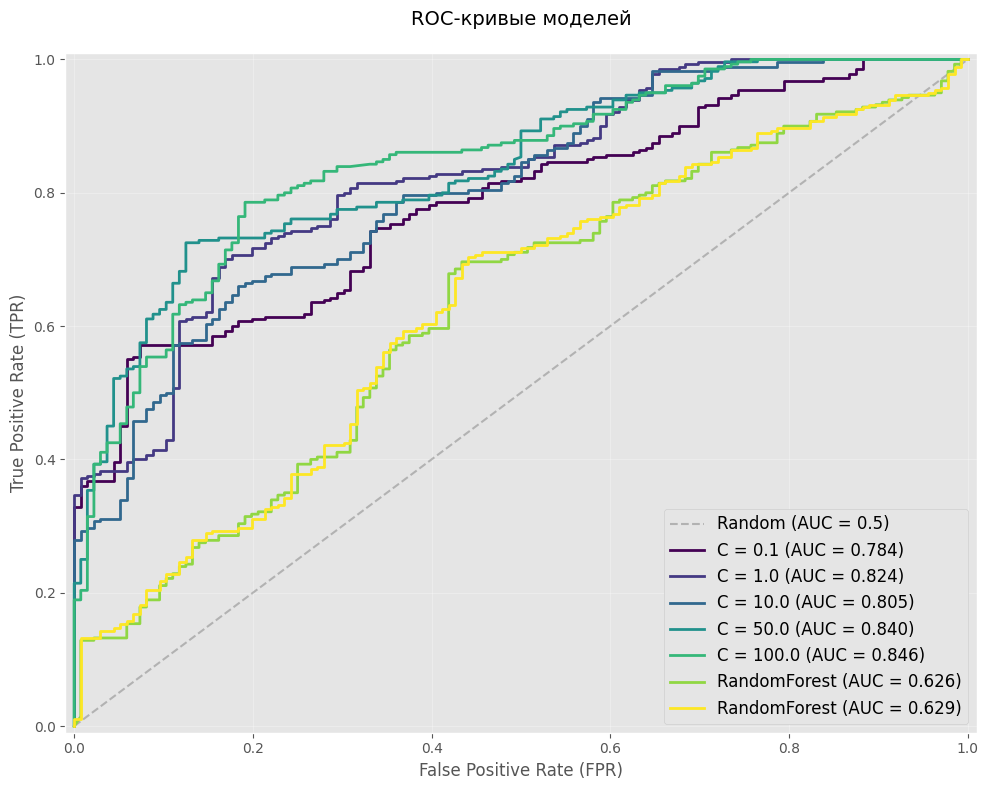

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=1000, class_weight="balanced", max_depth=8, random_state=42)
clf_rf.fit(X_train, y_train)
# y_pred_all = []
# proba_all = []
# clf_name = []
y_pred_all += [clf_rf.predict(X_val)]
proba_all += [clf_rf.predict_proba(X_val)[:, 1]]
clf_name += ["RandomForest"]
draw_roc_curve(y_val, proba_all, y_pred_all, clf_name)

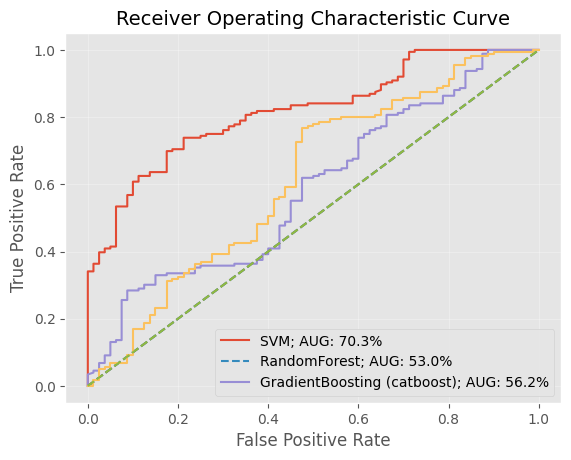

In [126]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gb = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    min_samples_leaf=15,
    subsample=0.8,
    max_features='sqrt',
    #n_iter_no_change=50,
    random_state=42,
)
clf_gb.fit(X_train, y_train)
# y_pred_all = []
# proba_all = []
# clf_name = []
y_pred_all += [clf_gb.predict(X_val)]
proba_all += [clf_gb.predict_proba(X_val)[:, 1]]
clf_name += ["GradientBoosting (catboost)"]
draw_infograph(y_val, proba_all, y_pred_all, clf_name)

0:	learn: 0.6484368	total: 26ms	remaining: 26s
1:	learn: 0.6146660	total: 40ms	remaining: 19.9s
2:	learn: 0.5871435	total: 54.4ms	remaining: 18.1s
3:	learn: 0.5503627	total: 68.6ms	remaining: 17.1s
4:	learn: 0.5280119	total: 84ms	remaining: 16.7s
5:	learn: 0.5132585	total: 98.2ms	remaining: 16.3s
6:	learn: 0.4918295	total: 114ms	remaining: 16.1s
7:	learn: 0.4711654	total: 128ms	remaining: 15.9s
8:	learn: 0.4514500	total: 143ms	remaining: 15.8s
9:	learn: 0.4358562	total: 157ms	remaining: 15.6s
10:	learn: 0.4180652	total: 173ms	remaining: 15.5s
11:	learn: 0.4016801	total: 188ms	remaining: 15.5s
12:	learn: 0.3912846	total: 203ms	remaining: 15.4s
13:	learn: 0.3797312	total: 219ms	remaining: 15.4s
14:	learn: 0.3681126	total: 236ms	remaining: 15.5s
15:	learn: 0.3594100	total: 251ms	remaining: 15.4s
16:	learn: 0.3534093	total: 265ms	remaining: 15.3s
17:	learn: 0.3465065	total: 279ms	remaining: 15.2s
18:	learn: 0.3410660	total: 293ms	remaining: 15.1s
19:	learn: 0.3338450	total: 308ms	remaining

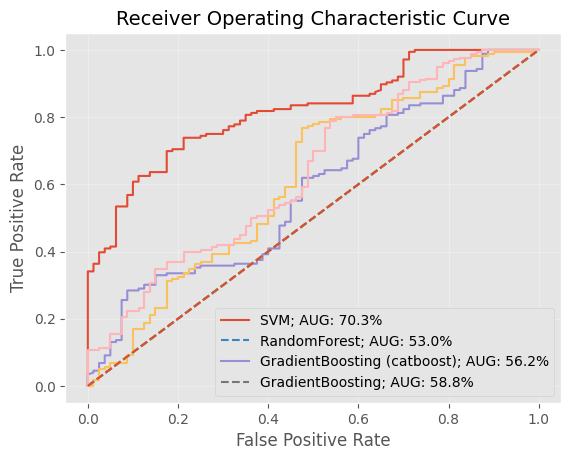

In [127]:
from catboost import CatBoostClassifier

clf_cat = CatBoostClassifier(iterations=1000, 
                            learning_rate=0.1,
                            #max_depth=5,
                            #min_data_in_leaf=2,
                            #l2_leaf_reg=1.0
                            )
clf_cat.fit(X_train, y_train)
# y_pred_all = []
# proba_all = []
# clf_name = []
y_pred_all += [clf_cat.predict(X_val)]
proba_all += [clf_cat.predict_proba(X_val)[:, 1]]
clf_name += ["GradientBoosting"]
draw_infograph(y_val, proba_all, y_pred_all, clf_name)

In [82]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
def create_default_dataloader(X: pd.DataFrame, y: pd.Series, test_size: float=0.2, random_state: int=42, batch_size: int=32, n_components=50, pca_on=True) -> tuple:
    idx = pd.IndexSlice
    if pca_on:
        pca = PCA(n_components)
        X = pd.DataFrame(pca.fit_transform(X), index=X.index)
    y_buf = y.groupby(level=1).max()
    y_train, y_val = train_test_split(y_buf, stratify=y_buf, test_size=test_size, random_state=random_state)
    X_train = X.loc[idx[:, y_train.index, :]]
    X_val = X.loc[idx[:, y_val.index, :]]
    y_train = y.loc[idx[:, y_train.index, :]]
    y_val = y.loc[idx[:, y_val.index, :]]
    #X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    labels_train = torch.tensor(y_train.to_numpy())
    labels_val = torch.tensor(y_val.to_numpy())
    data_train = torch.tensor(X_train.to_numpy(), dtype=torch.float)
    data_val = torch.tensor(X_val.to_numpy(), dtype=torch.float)
    
    train_dataset = TensorDataset(data_train, labels_train)
    val_dataset = TensorDataset(data_val, labels_val)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    return train_dataloader, val_dataloader, X_val

class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim, activation: str="leaky_relu"):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dims = hidden_dims
        self.out_dim = out_dim
        activations = {"leaky_relu": nn.LeakyReLU, "relu": nn.ReLU, "sigmoid": nn.Sigmoid, "tanh": nn.Tanh}

        self.first_layer = nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dims[0]),
            nn.BatchNorm1d(self.hidden_dims[0]),
            activations[activation](),
        )

        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
            nn.Linear(self.hidden_dims[i], self.hidden_dims[i + 1]),
            nn.BatchNorm1d(self.hidden_dims[i + 1]),
            activations[activation](),
            ) for i in range(len(self.hidden_dims) - 1)])

        self.last_layer = nn.Sequential(
            nn.Linear(self.hidden_dims[-1], out_dim),
            #nn.Sigmoid()
        )

    def forward(self, x):
        out = self.first_layer(x)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.last_layer(out)
        return out

In [77]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
def train(model, epochs, optim, criterion, train_dataloader, val_dataloader, scheduler=None, logging=False, tqdm_desc="Processed") -> tuple:
    losses_train = []
    losses_val = []
    acc = []
    device = "cuda" if next(model.parameters()).is_cuda else "cpu"
    for epoch in tqdm(range(epochs), desc=tqdm_desc):
        loss_train = []
        loss_val = []
        model.train()
        for batch, labels in train_dataloader:
            optim.zero_grad()
            batch = batch.to(torch.float)
            labels = labels.to(device)
            logits = model(batch.to(device)).squeeze().to(torch.float)

            loss = criterion(logits, labels.to(torch.float))
            loss.backward()
            optim.step()

            loss_train.append(loss.detach().cpu().numpy())

        losses_train.append(sum(loss_train) / len(loss_train))

        model.eval()
        preds_epoch = np.array([])
        labels_epoch = np.array([])
        for batch, labels in val_dataloader:
            with torch.no_grad():
                batch = batch.to(torch.float)
                logits = model(batch.to(device)).squeeze().to(torch.float)
                preds = (logits > 0.5).to(torch.int)
                loss = criterion(logits, labels.to(torch.float).to(device))
                loss_val.append(loss.detach().cpu().numpy())
                preds_epoch = np.concatenate((preds_epoch, preds.detach().cpu().numpy()))
                labels_epoch = np.concatenate((labels_epoch, labels.detach().cpu().numpy()))


        losses_val.append(sum(loss_val) / len(loss_val))
        acc.append(accuracy_score(labels_epoch, preds_epoch))
        if scheduler != None:
            scheduler.step()
        if len(acc) == 1:
            best_params = model.state_dict()
        elif acc[-1] > acc[-2]:
            best_params = model.state_dict()

        if logging:
            print(f"Epoch {epoch + 1}:")
            print(f"Train loss: {losses_train[-1]:.2f}, Val loss: {losses_val[-1]:.2f}, Accuracy: {acc[-1]:.2f}\n")
    print(f"Training complete successfully. Best accuracy on validation: {max(acc):.4f}")
    return losses_train, losses_val, acc, best_params

In [78]:
class ImprovedDiscriminator(nn.Module):
    def __init__(self, in_dim=147, hidden_dims=[256, 128, 64], out_dim=1, 
                 activation="leaky_relu", dropout_rate=0.3):
        super().__init__()
        
        # Расширенный набор активаций
        activations = {
            "leaky_relu": nn.LeakyReLU(0.2),  # Добавлен отрицательный slope
            "relu": nn.ReLU(),
            "selu": nn.SELU(),  # Новый вариант
            "gelu": nn.GELU(),   # Современная активация
            "sigmoid": nn.Sigmoid()
        }
        
        # Проверка входных параметров
        assert activation in activations, f"Активация {activation} не поддерживается"
        
        # Улучшенный первый слой
        self.first_block = nn.Sequential(
            nn.Linear(in_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.Dropout(dropout_rate),
            activations[activation]
        )
        
        # Скрытые блоки с residual-связями
        self.hidden_blocks = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            block = nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.BatchNorm1d(hidden_dims[i+1]),
                nn.Dropout(dropout_rate),
                activations[activation]
            )
            self.hidden_blocks.append(block)
        
        # Улучшенный выходной слой
        self.output = nn.Sequential(
            nn.Linear(hidden_dims[-1], out_dim),
        )
        
        # Инициализация весов
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.first_block(x)
        for block in self.hidden_blocks:
            residual = x  # Residual connection
            x = block(x)
            if x.shape == residual.shape:  # Добавляем residual, если размерности совпадают
                x = x + residual
        return self.output(x)

In [83]:
X = df.loc[:, "D401":"D676"].copy()
y = pd.Series([1 if x == "Parkinson" else 0 for x in df_norm.index.get_level_values("GROUP").to_list()], index = df_norm.index)
n_components=100
train_dataloader, val_dataloader, X_val = create_default_dataloader(X, y, test_size=0.25, batch_size=256, random_state=33, pca_on=False, n_components=n_components)

In [ ]:
in_dim = len(X_val.columns)
model = ImprovedDiscriminator(
    in_dim=in_dim,
    hidden_dims=[256, 128, 128, 64],  # Более глубокая архитектура
    activation='gelu',  # Можно экспериментировать
    dropout_rate=0.1
)
#model = Discriminator(len(X_val.columns), hidden_dims=[256, 128, 64], out_dim=1, activation="leaky_relu")

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4,  # Уменьшенный LR
    #weight_decay=1e-6  # Меньше регуляризации
)

# Изменяем шедулер
scheduler=None
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=0.98, step_size=1)


weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# Функция потерь
criterion = nn.BCEWithLogitsLoss(weight=torch.tensor([weight]))


epochs = 200
losses_train, losses_val, acc, best_params = train(model, epochs=epochs, optim=optimizer, criterion=criterion, train_dataloader=train_dataloader, val_dataloader=val_dataloader, scheduler=scheduler)

Processed:   0%|          | 0/200 [00:00<?, ?it/s]

Processed: 100%|██████████| 200/200 [00:05<00:00, 35.12it/s]

Training complete successfully. Best accuracy on validation: 0.8438


In [89]:
def predict(model, val_dataloader):
    device = "cuda" if next(model.parameters()).is_cuda else "cpu"
    model.to(device)
    model.eval()
    preds_all = np.array([])
    proba_all = np.array([])
    labels_all = np.array([])
    for batch, labels in val_dataloader:
        with torch.no_grad():
            batch = batch.to(torch.float)
            logits = model(batch.to(device)).squeeze().to(torch.float)
            preds = (logits > 0.5).to(torch.int)
            proba = torch.sigmoid(logits)
            preds_all = np.concatenate((preds_all, preds.detach().cpu().numpy()))
            labels_all = np.concatenate((labels_all, labels.detach().cpu().numpy()))
            proba_all = np.concatenate((proba_all, proba.detach().cpu().numpy()))

    return preds_all, proba_all, labels_all

Text(0.5, 1.0, 'Распределение выходов модели')

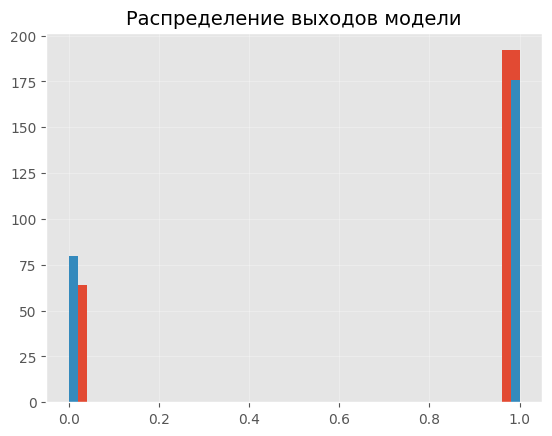

In [128]:
preds, proba, labels = predict(model, val_dataloader)
plt.hist(preds, bins=25)
plt.hist(labels, bins=50)
plt.title("Распределение выходов модели")

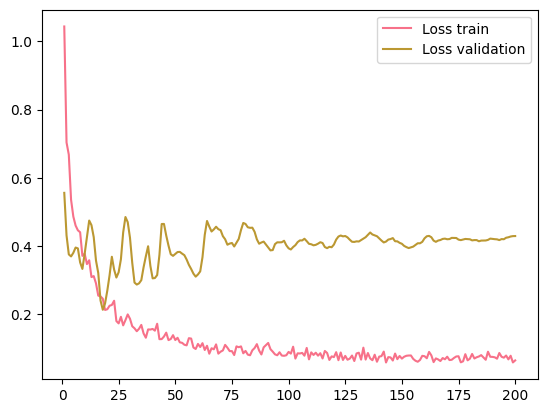

In [91]:
plt.plot(range(1, epochs + 1), losses_train)
plt.plot(range(1, epochs + 1), losses_val)
plt.legend(["Loss train", "Loss validation"])

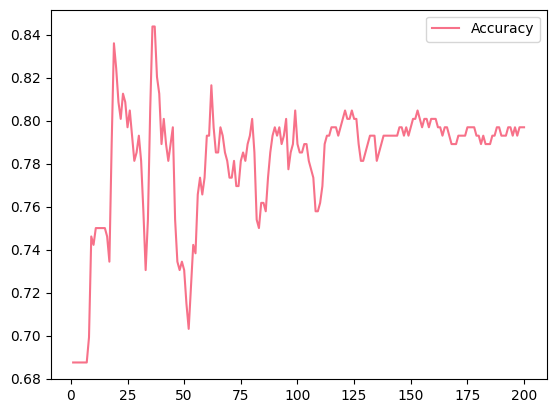

In [92]:
plt.plot(range(1, epochs + 1), acc)
plt.legend(["Accuracy"])

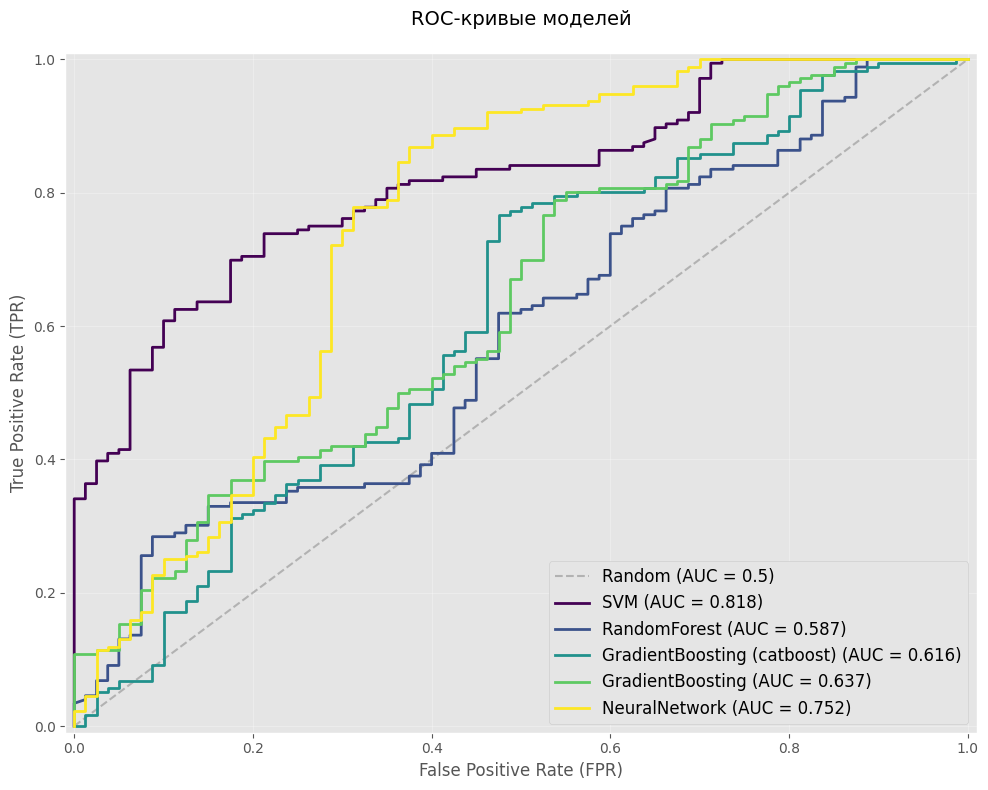

In [129]:
draw_roc_curve(y_val, proba_all + [proba], y_pred_all + [preds], clf_name + ["NeuralNetwork"])

In [123]:
len(y_pred_all)

3

In [130]:
from sklearn.metrics import precision_score, accuracy_score, recall_score
for proba, y_pred, name in zip(proba_all + [proba], y_pred_all + [preds], clf_name + ["NeuralNetwork"]):
    print(f"{name} classifier:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
    print(f"Precision: {precision_score(y_val, y_pred):.2f}")
    print(f"Recall: {recall_score(y_val, y_pred):.2f}")
    print()

SVM classifier:
Accuracy: 0.75
Precision: 0.81
Recall: 0.82

RandomForest classifier:
Accuracy: 0.67
Precision: 0.70
Recall: 0.90

GradientBoosting (catboost) classifier:
Accuracy: 0.68
Precision: 0.72
Recall: 0.88

GradientBoosting classifier:
Accuracy: 0.70
Precision: 0.73
Recall: 0.88

NeuralNetwork classifier:
Accuracy: 0.80
Precision: 0.82
Recall: 0.90

